## Importing Libraries

In [1]:
import pandas as pd
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import discrete_allocation
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import base_optimizer
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.hierarchical_portfolio import HRPOpt

C:\Users\ruchd\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ruchd\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\ruchd\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Getting the Data

In [2]:
# Define the ticker list
tickers_list = ['AAPL', 'WMT', 'MU', 'BA','GOOG','BABA','GE','AMD','BAC','GM','T','UAA','XOM','RRC','PFE','JPM','SBUX']

# Fetch the data
import yfinance as yf
data = yf.download(tickers_list,start ='2022-7-1',end ='2023-6-30')['Adj Close']
#print(data.iloc[-1])
# Print first 5 rows of the data
print(data.head())
#print(data.tail())

[*********************100%***********************]  17 of 17 completed
                  AAPL        AMD          BA        BABA        BAC  \
Date                                                                   
2022-07-01  138.105347  73.669998  139.839996  116.000000  30.725134   
2022-07-05  140.719742  75.199997  137.699997  120.129997  30.413601   
2022-07-06  142.071655  75.349998  136.309998  119.120003  30.160477   
2022-07-07  145.481308  79.300003  139.970001  122.389999  31.017199   
2022-07-08  146.167191  79.349998  139.070007  120.900002  30.949051   

                   GE         GM        GOOG         JPM         MU  \
Date                                                                  
2022-07-01  49.446747  31.882139  109.081001  110.359825  53.203587   
2022-07-05  48.271667  32.060417  113.887001  109.940063  56.257957   
2022-07-06  47.913689  30.970942  115.213501  109.227425  56.892632   
2022-07-07  49.026516  32.347649  119.306000  111.990089  58.360317  

## Markowitz with Sharpe maximization

In [3]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = data

# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

# add a secondary objective
#ef.add_objective(objective_functions.L2_reg)

# Efficient Frontier with random portfolios

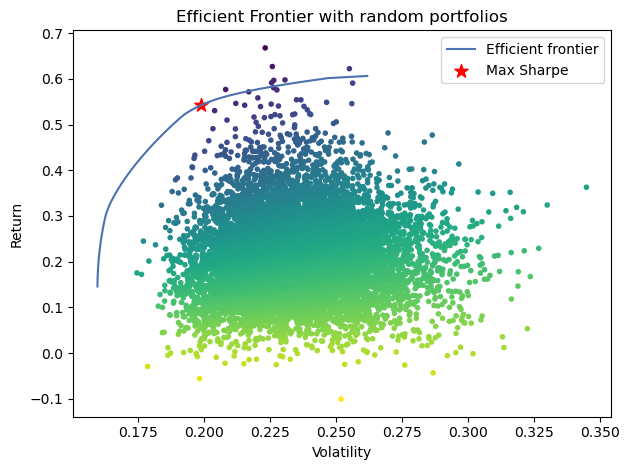

In [4]:
import pypfopt.plotting as plotting
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
#plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [5]:
# Optimize for maximum Sharpe ratio

#weights = ef.max_sharpe()

#  print weights
cleaned_weights = ef_max_sharpe.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.18487), ('AMD', 0.0), ('BA', 0.16249), ('BABA', 0.0), ('BAC', 0.0), ('GE', 0.2), ('GM', 0.0), ('GOOG', 0.0), ('JPM', 0.11564), ('MU', 0.0), ('PFE', 0.0), ('RRC', 0.0), ('SBUX', 0.05262), ('T', 0.0), ('UAA', 0.0), ('WMT', 0.2), ('XOM', 0.08438)])


In [6]:
#to know the expected performance of the portfolio with optimal weights w
ef_max_sharpe.portfolio_performance(verbose=True)

Expected annual return: 54.2%
Annual volatility: 19.9%
Sharpe Ratio: 2.62


(0.5419212840060204, 0.19883978717047973, 2.6248332460672947)

In [7]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()

In [8]:
print("Optimal Allocation:", allocation)
print("Leftover:",leftover)

Optimal Allocation: {'GE': 18, 'WMT': 13, 'AAPL': 9, 'BA': 8, 'JPM': 8, 'XOM': 8, 'SBUX': 5}
Leftover: 27.530075073242188


In [9]:
def utility_optimal_portfolio(risk_aversion_coeff):
    # Importing libraries
    #from pypfopt import EfficientFrontier
    #from pypfopt import risk_models
    #from pypfopt import expected_returns
    #from pypfopt import objective_functions
    #latest_prices = historical_prices.iloc[-1]
 
    # Expected Returns
    #mu = expected_returns.mean_historical_return(pf_data)
    # Expected Volatility
    #Sigma = risk_models.sample_cov(pf_data)
    ef_ = EfficientFrontier(returns, cov_matrix)  # setup
    ef_.add_objective(objective_functions.L2_reg)  # add a secondary objective
    weights = ef_.max_quadratic_utility(risk_aversion=risk_aversion_coeff, market_neutral=False)  # find the portfolio that maximizes utility
    ret,vol,sharpe_r = ef_.portfolio_performance()
    da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=30000)
    allocation, leftover = da.greedy_portfolio()
    # loop to iterate for values  
    res = dict() 
    for key in weights:  
    # rounding to K using round() 
        res[key] = round(weights[key], 2) 
    
    return "Allocation " + str(res),'Annualised Reutrn ' + str(round(ret,2)),'Annualised Volatility ' + str(round(vol,2)),'Sharpe Ratio ' + str(round(sharpe_r,2)),'Allocation ' + str(allocation),'Leftover fund ' + str(leftover) 

In [10]:
# Aggressive Investor
utility_optimal_portfolio(1)

("Allocation {'AAPL': 0.09, 'AMD': 0.14, 'BA': 0.13, 'BABA': 0.0, 'BAC': 0.0, 'GE': 0.49, 'GM': 0.0, 'GOOG': 0.0, 'JPM': 0.05, 'MU': 0.0, 'PFE': 0.0, 'RRC': 0.0, 'SBUX': 0.03, 'T': 0.0, 'UAA': 0.0, 'WMT': 0.05, 'XOM': 0.03}",
 'Annualised Reutrn 0.83',
 'Annualised Volatility 0.25',
 'Sharpe Ratio 3.28',
 "Allocation {'GE': 134, 'AMD': 36, 'BA': 19, 'AAPL': 13, 'WMT': 10, 'JPM': 10, 'SBUX': 8, 'XOM': 7}",
 'Leftover fund 76.26005554199219')

In [11]:
# Moderate Investor
utility_optimal_portfolio(4)

("Allocation {'AAPL': 0.09, 'AMD': 0.09, 'BA': 0.12, 'BABA': 0.0, 'BAC': 0.0, 'GE': 0.47, 'GM': 0.0, 'GOOG': 0.0, 'JPM': 0.06, 'MU': 0.0, 'PFE': 0.0, 'RRC': 0.0, 'SBUX': 0.04, 'T': 0.0, 'UAA': 0.0, 'WMT': 0.09, 'XOM': 0.04}",
 'Annualised Reutrn 0.8',
 'Annualised Volatility 0.23',
 'Sharpe Ratio 3.36',
 "Allocation {'GE': 129, 'BA': 17, 'AMD': 23, 'AAPL': 14, 'WMT': 17, 'JPM': 11, 'XOM': 12, 'SBUX': 13}",
 'Leftover fund 57.440162658691406')

In [12]:
# Risk-Averse Investor
utility_optimal_portfolio(10)

("Allocation {'AAPL': 0.09, 'AMD': 0.04, 'BA': 0.1, 'BABA': 0.0, 'BAC': 0.0, 'GE': 0.44, 'GM': 0.0, 'GOOG': 0.0, 'JPM': 0.06, 'MU': 0.0, 'PFE': 0.0, 'RRC': 0.0, 'SBUX': 0.06, 'T': 0.0, 'UAA': 0.0, 'WMT': 0.14, 'XOM': 0.07}",
 'Annualised Reutrn 0.75',
 'Annualised Volatility 0.22',
 'Sharpe Ratio 3.39',
 "Allocation {'GE': 119, 'WMT': 27, 'BA': 14, 'AAPL': 14, 'XOM': 19, 'JPM': 13, 'SBUX': 19, 'AMD': 10}",
 'Leftover fund 62.460289001464844')

## Markowitz with Target Volatility

In [13]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
#historical_prices = data
target_volatility = 0.2


# Calculate expected returns
#returns = expected_returns.mean_historical_return(historical_prices)
#cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
ef_tv = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))

# add a secondary objective
ef_tv.add_objective(objective_functions.L2_reg)

ef_tv.efficient_risk(target_volatility)

OrderedDict([('AAPL', 0.1219642205739029),
             ('AMD', 0.0435137684915394),
             ('BA', 0.1278472538085894),
             ('BABA', 1.349621e-10),
             ('BAC', 2.906782e-10),
             ('GE', 0.1999999999421806),
             ('GM', 8.555174e-10),
             ('GOOG', 1.6463702e-09),
             ('JPM', 0.111079403367694),
             ('MU', 1.7820343e-09),
             ('PFE', 7.02011e-10),
             ('RRC', 2.0579387e-09),
             ('SBUX', 0.0976030185913006),
             ('T', 7.975664e-10),
             ('UAA', 5.94079e-11),
             ('WMT', 0.1911560038593286),
             ('XOM', 0.1068363230393458)])

In [14]:
#plotting.plot_efficient_frontier(ef_tv, show_assets=True, show_tickers=True)

In [15]:
#  print weights
cleaned_weights = ef_tv.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.12196), ('AMD', 0.04351), ('BA', 0.12785), ('BABA', 0.0), ('BAC', 0.0), ('GE', 0.2), ('GM', 0.0), ('GOOG', 0.0), ('JPM', 0.11108), ('MU', 0.0), ('PFE', 0.0), ('RRC', 0.0), ('SBUX', 0.0976), ('T', 0.0), ('UAA', 0.0), ('WMT', 0.19116), ('XOM', 0.10684)])


In [16]:
#to know the expected performance of the portfolio with optimal weights w
ef_tv.portfolio_performance(verbose=True)

Expected annual return: 53.7%
Annual volatility: 20.0%
Sharpe Ratio: 2.58


(0.5368576098583648, 0.2000000002667545, 2.5842880458449717)

In [17]:
# Calculate the discrete allocation of assets based on the optimal weights
#latest_prices = historical_prices.iloc[-1]  # Latest prices for the assets
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()

In [18]:
print("Optimal Allocation:", allocation)
print("Leftover:",leftover)

Optimal Allocation: {'GE': 18, 'WMT': 12, 'BA': 6, 'AAPL': 6, 'JPM': 8, 'XOM': 10, 'SBUX': 10, 'AMD': 4}
Leftover: 23.500076293945312


## Markowitz with Monthly Rebalancing keeping Original Weights Only

## Markowitz with Monthly Rebalancing - With Original Weights Revising every 12 months

In [19]:
monthly_prices = historical_prices.copy()
#monthly_prices['MonthNumber'] = historical_prices.index.month
#monthly_prices['YearNumber'] = historical_prices.index.year
#monthly_prices["Concatkey"] = monthly_prices['MonthNumber'].astype(str) +"-"+ monthly_prices["YearNumber"].astype(str)
#grouped_monthly_prices = monthly_prices.groupby(['Concatkey'],sort=False)
'''for month_year, group in grouped_monthly_prices:
    # Print the month number and the corresponding group data
    #print(f"Month: {month_year}")
    #print(group)
    prices_new = group
    #prices_new = prices.copy()
    prices_new = prices_new.loc[:, ~prices_new.columns.isin(['MonthNumber', 'YearNumber',' Concatkey'])]
    print(prices_new)'''
'''for month, group in monthly_prices.groupby(pd.Grouper(freq='3M')):
    # Print the month and the corresponding group data
    print(f"Month: {month}")
    print(group)
    print()'''

'for month, group in monthly_prices.groupby(pd.Grouper(freq=\'3M\')):\n    # Print the month and the corresponding group data\n    print(f"Month: {month}")\n    print(group)\n    print()'

In [20]:
# Create an empty DataFrame to store allocation results
allocation_history = pd.DataFrame(columns=tickers_list)

# Set initial portfolio value
portfolio_value = 30000

# Set rebalancing frequency (in months)
#rebalancing_frequency = 1

# Iterate over each month
for month, group in monthly_prices.groupby(pd.Grouper(freq='Q')):
    prices = group
    #prices_new = prices.copy()
    #prices_new = prices_new.loc[:, ~prices_new.columns.isin(['MonthNumber','YearNumber','Concatkey'])]
    #target_volatility = 0.2
    
    # Calculate expected returns and covariance matrix
    returns = expected_returns.mean_historical_return(prices)
    cov_matrix = risk_models.sample_cov(prices)

    # Create an instance of EfficientFrontier
    ef = EfficientFrontier(returns, cov_matrix, weight_bounds=(0, 0.2))

    #ef.add_objective(objective_functions.L2_reg)
    
    # Optimize for maximum Sharpe ratio
    weights = ef.max_sharpe()

    #ef.efficient_risk(target_volatility)
    
    # Clean the weights for assets below the lower weight bound
    cleaned_weights = ef.clean_weights()

    # Calculate the discrete allocation of assets based on the optimal weights
    #latest_prices = prices.iloc[-1]  # Latest prices for the assets
    #da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
    #allocation, _ = da.greedy_portfolio()

    # Store the allocation for the current month
    allocation_history = allocation_history.append(cleaned_weights, ignore_index=True)

# Print the allocation history
print(allocation_history)

   AAPL      WMT   MU   BA  GOOG  BABA   GE      AMD  BAC       GM        T  \
0   0.2  0.20000  0.0  0.0   0.0   0.0  0.0  0.00000  0.0  0.11702  0.00000   
1   0.0  0.00000  0.0  0.2   0.0   0.0  0.2  0.00000  0.0  0.00000  0.20000   
2   0.2  0.12285  0.0  0.0   0.0   0.0  0.2  0.20000  0.0  0.00000  0.16077   
3   0.2  0.20000  0.0  0.0   0.2   0.0  0.2  0.02042  0.0  0.00000  0.00000   

       UAA      XOM      RRC  PFE      JPM  SBUX  
0  0.00000  0.20000  0.08298  0.0  0.00000   0.2  
1  0.04475  0.10356  0.00000  0.2  0.05168   0.0  
2  0.00000  0.11638  0.00000  0.0  0.00000   0.0  
3  0.00000  0.00000  0.02510  0.0  0.15449   0.0  


C:\Users\ruchd\AppData\Local\Temp\ipykernel_18852\2314015824.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allocation_history = allocation_history.append(cleaned_weights, ignore_index=True)
C:\Users\ruchd\AppData\Local\Temp\ipykernel_18852\2314015824.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allocation_history = allocation_history.append(cleaned_weights, ignore_index=True)
C:\Users\ruchd\AppData\Local\Temp\ipykernel_18852\2314015824.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allocation_history = allocation_history.append(cleaned_weights, ignore_index=True)
C:\Users\ruchd\AppData\Local\Temp\ipykernel_18852\2314015824.py:40: FutureWarning: The frame.append method is deprecated and will be removed f

In [21]:
data = yf.download(tickers_list,'2020-7-1')['Adj Close']
monthly_prices_ = data.copy()
# Create an empty DataFrame to store allocation results
allocation_history = pd.DataFrame(columns=tickers_list)

# Set initial portfolio value
portfolio_value = 30000

# Set rebalancing frequency (in months)
#rebalancing_frequency = 1

# Iterate over each month
for month, group in monthly_prices_.groupby(pd.Grouper(freq='Q')):
    prices = group
    #prices_new = prices.copy()
    #prices_new = prices_new.loc[:, ~prices_new.columns.isin(['MonthNumber','YearNumber','Concatkey'])]
    #target_volatility = 0.2
    
    # Calculate expected returns and covariance matrix
    returns = expected_returns.mean_historical_return(prices)
    cov_matrix = risk_models.sample_cov(prices)

    # Create an instance of EfficientFrontier
    ef = EfficientFrontier(returns, cov_matrix, weight_bounds=(0, 0.2))

    #ef.add_objective(objective_functions.L2_reg)
    
    # Optimize for maximum Sharpe ratio
    weights = ef.max_sharpe()

    #ef.efficient_risk(target_volatility)
    
    # Clean the weights for assets below the lower weight bound
    cleaned_weights = ef.clean_weights()

    # Calculate the discrete allocation of assets based on the optimal weights
    #latest_prices = prices.iloc[-1]  # Latest prices for the assets
    #da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
    #allocation, _ = da.greedy_portfolio()

    # Store the allocation for the current month
    allocation_history = allocation_history.append(cleaned_weights, ignore_index=True)

# Print the allocation history
print(allocation_history)

[*********************100%***********************]  17 of 17 completed
       AAPL      WMT       MU   BA   GOOG     BABA       GE      AMD      BAC  \
0   0.00000  0.20000  0.00000  0.0  0.000  0.20000  0.00000  0.20000  0.00000   
1   0.09025  0.20000  0.20000  0.0  0.000  0.04964  0.20000  0.00000  0.00000   
2   0.00000  0.00000  0.00000  0.0  0.193  0.00000  0.04246  0.00000  0.18006   
3   0.15507  0.17635  0.00000  0.0  0.200  0.00000  0.00000  0.06858  0.00000   
4   0.04754  0.20000  0.00000  0.0  0.200  0.00000  0.00000  0.10395  0.00000   
5   0.20000  0.20000  0.15387  0.0  0.000  0.00000  0.00000  0.12170  0.05724   
6   0.06702  0.20000  0.00000  0.0  0.000  0.00000  0.00524  0.00000  0.09548   
7   0.00000  0.03045  0.00000  0.0  0.000  0.20000  0.00000  0.00000  0.00000   
8   0.20000  0.20000  0.00000  0.0  0.000  0.00000  0.00000  0.00000  0.00000   
9   0.00000  0.00000  0.00000  0.2  0.000  0.00000  0.20000  0.00000  0.00000   
10  0.20000  0.12285  0.00000  0.0  0.

C:\Users\ruchd\AppData\Local\Temp\ipykernel_18852\2358742541.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allocation_history = allocation_history.append(cleaned_weights, ignore_index=True)
C:\Users\ruchd\AppData\Local\Temp\ipykernel_18852\2358742541.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allocation_history = allocation_history.append(cleaned_weights, ignore_index=True)
C:\Users\ruchd\AppData\Local\Temp\ipykernel_18852\2358742541.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allocation_history = allocation_history.append(cleaned_weights, ignore_index=True)
C:\Users\ruchd\AppData\Local\Temp\ipykernel_18852\2358742541.py:42: FutureWarning: The frame.append method is deprecated and will be removed f